        ## The evolution here is only according to z-orientation pulse field

1. H = K + V
2. K = 0 ; particle at rest; 
3. H = V
4. V = zeeman interaction
5. V = (g_e * bohr_magneton / h_cut) * B * S
6. V = gyro_con*B*S
        # We choose a coordinate (pulse dir) system so that B is pointing in the z dir;
1. B.S = Bz.Sz
2. Sz = pauli matrix in z direction measurement
3. also, omega = B*gyro_con
4. therefore the time_period of precession -> T = 2*pi/omega
5. V = omega*S

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.fftpack as sft

In [2]:
class electron_evolution:
    
    def __init__(self, Bz):
        #self.prepared_state = prepared_state
        #self.measured_state = measured_state
        #self.time_grid = time_grid
        #self.omega = omega
        self.Bz = Bz
        self.h_cut = 1
        self.m_e = 1
        self.e_charge = 1
        self.g_e = 2.002319
        self.bohr_magneton = self.e_charge*self.h_cut/(2*self.m_e)
        self.gyro_con = (self.g_e/self.h_cut)*self.bohr_magneton
        self.omega = self.g_e*self.bohr_magneton*self.Bz/self.h_cut
    
    def spin_function(self,spin_state):
        if spin_state == "spin_up":
            mat = np.array([[1], [0]])
            return mat
        elif spin_state == "spin_down":
            mat = np.array([[0],[1]])
            return mat
        elif spin_state == "spin_right":   # +x
            mat = np.array([[1],[1]])
            return mat
        elif spin_state == "spin_left":    # -x
            mat = np.array([[1], [-1]])
            return mat
        elif spin_state == "spin_out":   # +y
            mat = np.array([[1],[1j]])
            return mat
        elif spin_state == "spin_in":    # -y
            mat = np.array([[1], [-1j]])
            return mat
    
    def inner_product(self,left_vec, right_vec):
        bra = (np.conj(left_vec)).T
        ket = right_vec
        inner_prod = bra @ ket
        return inner_prod
    
    def norm_column_vec(self, x):
        # m, n = x.shape
        inner_pro = self.inner_product(x, x)
        # inner_prodcut is still a 1x1 array, lets extract the element and take its sqrt
        norm = np.sqrt(np.squeeze(inner_pro))
        x_norm = x / norm
        return x_norm

    def tdse_z(self,prepared_state, t):
        spin_mat = self.spin_function(prepared_state)
        a_0 = np.squeeze(spin_mat[0])
        b_0 = np.squeeze(spin_mat[1])

        a = a_0*np.exp(-1.0j*self.omega*t/2)
        b = b_0*np.exp(1.0j*self.omega*t/2)
        eigen_vec_t = np.array([[a], [b]])
        eigen_vec_t = self.norm_column_vec(eigen_vec_t)

        return eigen_vec_t
    
    def probability_cal(self,prepared_state, t, measured_state):
        eigen_vec_t = self.tdse_z(prepared_state, t)
        measured_state = self.spin_function(measured_state)
        measured_state = self.norm_column_vec(measured_state)
        probability = np.squeeze(np.square(self.inner_product(measured_state, eigen_vec_t)))
        
        return abs(probability)
    
    def prob_n_grid(self, prepared_state, measured_state, time):
        prob_t = []
        time_grid = 2*(np.pi/self.omega)*time
        
        # Creating freq grid for fourier transformed w.f.
        dt = time_grid[1] - time_grid[0]
        N = len(time_grid)
        spatial_freq = sft.fftfreq(N, dt)
        freq_grid = 2*np.pi*spatial_freq
        
        for t in time_grid:
            prob_t.append(self.probability_cal(prepared_state, t, measured_state))
        
        # fourier transformed measuring prob
        prob_om = sft.fft(prob_t)
        
        prob_dict = {"prob_time": prob_t, "prob_om": prob_om}
        grid_dict = {"time_grid": time_grid, "freq_grid":freq_grid}
        
        return prob_dict, grid_dict

In [3]:
Bz = 2
time = np.arange(0,10.1, 0.001)
method= electron_evolution(2)

In [4]:
prepared_state = "spin_right"
measured_state = "spin_right"
prob_dict, grid_dict = method.prob_n_grid(prepared_state, measured_state, time)

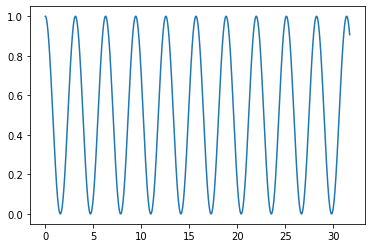

In [5]:
prob_t = prob_dict["prob_time"]
time_grid = grid_dict["time_grid"]
plt.plot(time_grid, prob_t)

                # Let's do the F.T. to find the periodicity of the w.f.

/home/user/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


(-5.0, 5.0)

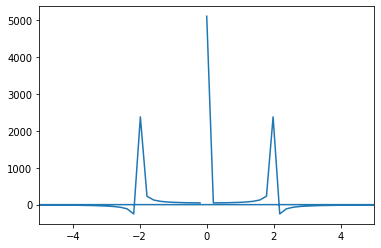

In [6]:
prob_om = prob_dict["prob_om"]
freq_grid = grid_dict["freq_grid"]
plt.plot(freq_grid, prob_om)
plt.xlim(-5,5)
# Therefore, it is visible that according to the pulse of Bz,
# the delta function is chagning accordingly.